# Markov Chain Monte Carlo

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mcmc_utils
import plot_utils

# Utility functions

In [2]:
def acceptance_ratio(trace, min_diff=0.0001):
    diffs = np.array(trace[1:]) - np.array(trace[:-1])
    abs_diff = np.abs(diffs)
    not_accepted_steps = abs_diff < min_diff
    return 1 - sum(not_accepted_steps) / (len(trace) - 1)

# Exercise 1

Use metropolis algorithm to infer posterior distribution. Compare different proposal distributions using trace analysis.

In [3]:
def bern_likelihood(theta, data):
    if theta > 1 or theta < 0:
        return 0
    z = sum(data)
    N = len(data)
    return theta ** z * (1 - theta) ** (N - z)


def metropolis_gen(
    target_prob_func,
    proposal_sd,
    starting_position=.1,
    trace_length=50000,
):
    '''
    Generate a 1D Metrolopis MCMC trace with normally distributed
    proposal.
    '''
    current_position = starting_position
    yield current_position
    for _ in range(trace_length - 1):
        proposed_jump = np.random.normal(0, proposal_sd)
        proposed_position = current_position + proposed_jump
        current_prob = target_prob_func(current_position)
        proposed_prob = target_prob_func(proposed_position)
        acceptance_prob = min(1, proposed_prob / current_prob)
        if np.random.uniform() < acceptance_prob:
            current_position = proposed_position
        yield current_position

In [4]:
data = [0] * 6 + [1] * 14
prior = stats.beta(1, 1).pdf
posterior = lambda theta: bern_likelihood(theta, data) * prior(theta)

In [5]:
%%time

trace_proposal_sd002 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=.02)))
trace_proposal_sd02 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=.2)))
trace_proposal_sd2 = np.array(list(metropolis_gen(target_prob_func=posterior, proposal_sd=2)))

CPU times: user 28.2 s, sys: 136 ms, total: 28.4 s
Wall time: 28.5 s


In [6]:
def plot_trace_analysis(trace : np.array):    
    effective_size = mcmc_utils.ess(trace)
    acc_ratio = acceptance_ratio(trace)
    hdi = np.percentile(trace, [2.5, 97.5])

    _, axes = plt.subplots(nrows=3, figsize=(8, 6), sharex=True)

    axes[0].set_title(f'Eff.Sz = {effective_size:.1f}')
    sns.distplot(trace, ax=axes[0], kde=False)
    plot_utils.hdi(hdi, ax=axes[0])

    axes[1].set_title('End of chain')
    N = len(trace)
    axes[1].plot(trace[-100:], np.arange(-100, 0) + N)
    axes[1].annotate(f'Acceptance ratio = {acc_ratio:.3f}', xy=(5, 5), xycoords='axes points')

    axes[2].set_title('Beginning of chain')
    axes[2].plot(trace[:100], range(100))
                      
    for ax in axes:
        ax.set_xlabel(r'$\theta$')
    
    plt.tight_layout()

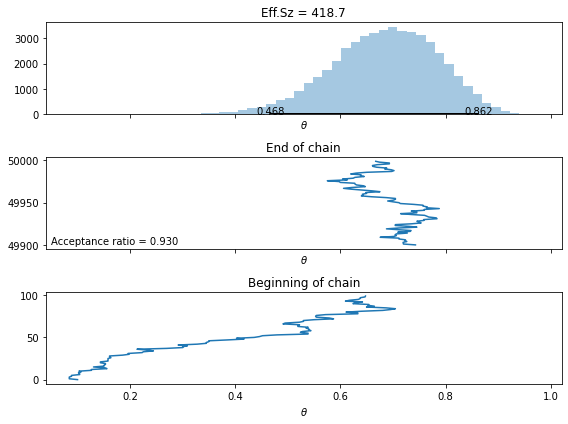

In [7]:
plot_trace_analysis(trace_proposal_sd002)

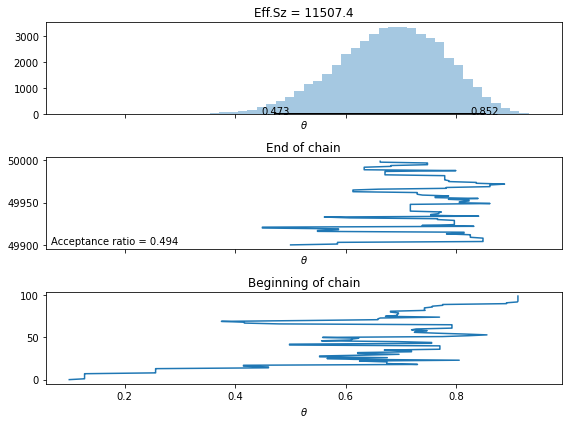

In [8]:
plot_trace_analysis(trace_proposal_sd02)

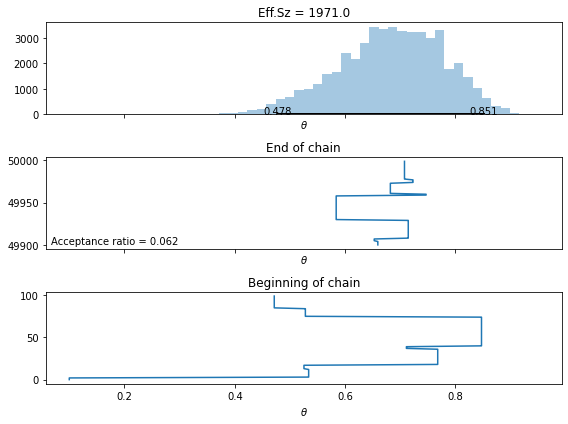

In [9]:
plot_trace_analysis(trace_proposal_sd2)

# Exercise 2

Rewrite some of Kruschke's analysis plots in python and use them with the traces from the previous exercise.

In [10]:
def plot_trace_lag_analysis(trace, example_lags=[2, 5, 10], max_lag=30):

    autocorrelation = {lag: mcmc_utils.acf(trace, lag) for lag in range(1, max_lag + 1)}

    plt.figure(figsize=(10, 10))

    # Plot results for different lags
    for column, lag in enumerate(example_lags, start=1):

        # Lag example plots of traces and spread
        truncated_trace = trace[:100]
        head_trace = truncated_trace[:-lag]
        tail_trace = truncated_trace[lag:]

        # Plotting
        ax = plt.subplot(3, len(example_lags), column)
        ax.plot(head_trace)
        ax.plot(tail_trace)
        ax.set_title(f'Lag = {lag}')

        ax = plt.subplot(3, len(example_lags), column + len(example_lags))
        ax.scatter(tail_trace, head_trace)
        ax.set_title(f'ACF({lag}) = {autocorrelation[lag]:.3f}')
        ax.set_xlabel('lagged value')
        ax.set_ylabel('value')

    # Autocorrelation function plotting
    ax = plt.subplot(3, 1, 3)
    ax.bar(autocorrelation.keys(), autocorrelation.values())
    ax.set_xlim([1, max_lag])
    ax.set_title('Trace autocorrelation function')
    ax.set_xlabel('lag')
    ax.set_ylabel('autocorrelation')

    plt.tight_layout()

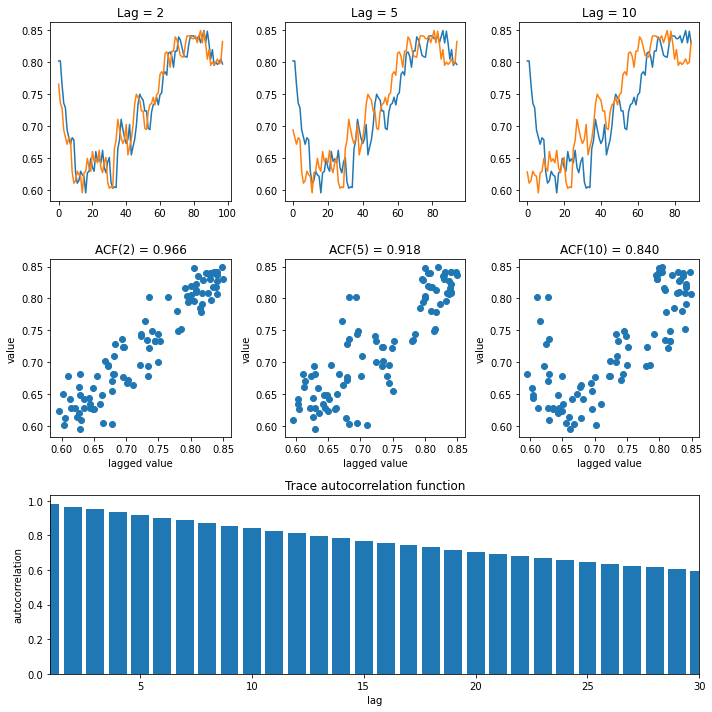

In [11]:
plot_trace_lag_analysis(trace_proposal_sd002[1000:])

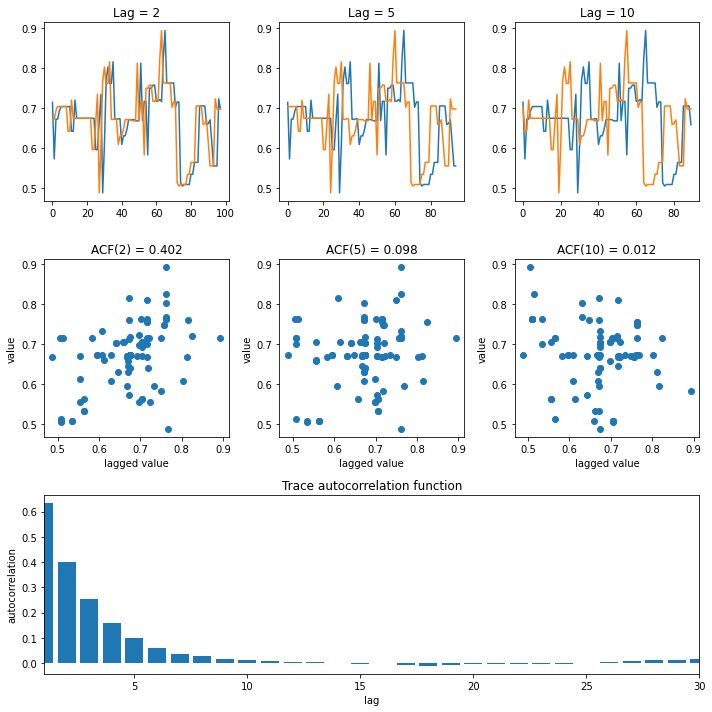

In [12]:
plot_trace_lag_analysis(trace_proposal_sd02[1000:])

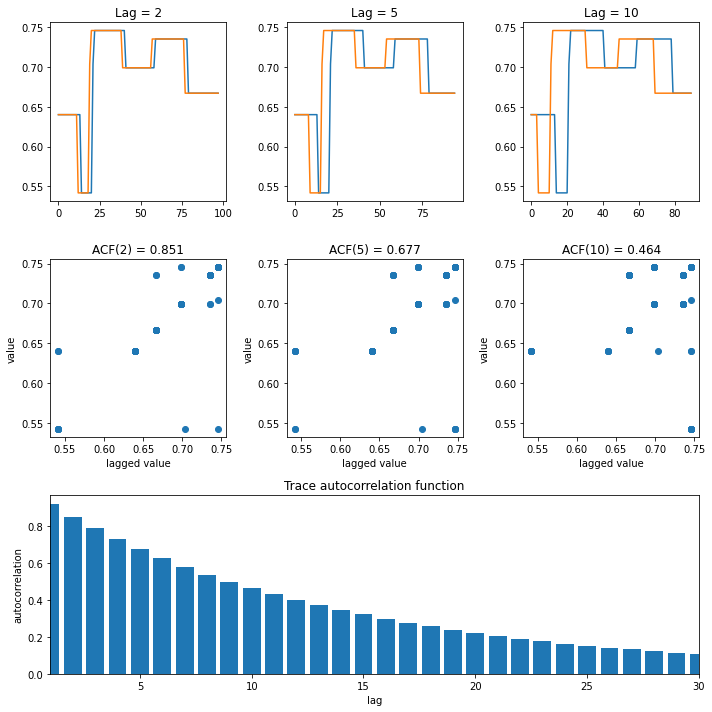

In [13]:
plot_trace_lag_analysis(trace_proposal_sd2[1000:])

# Exercise 3

Understand multimodal prior effects on the posterior through traces analysis.

### Questions A + B

Define a trimodal prior and plot it.

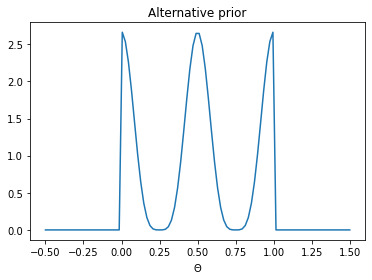

In [14]:
def prior(theta):
    window = stats.distributions.uniform.pdf(theta)
    return window * (np.cos(4 * np.pi * theta) + 1) ** 2 / 1.5

x = np.linspace(-0.5, 1.5, 100)
plt.plot(x, prior(x))
plt.title('Alternative prior')
_ = plt.xlabel('$\Theta$')

### Question C

Sampling from the prior.

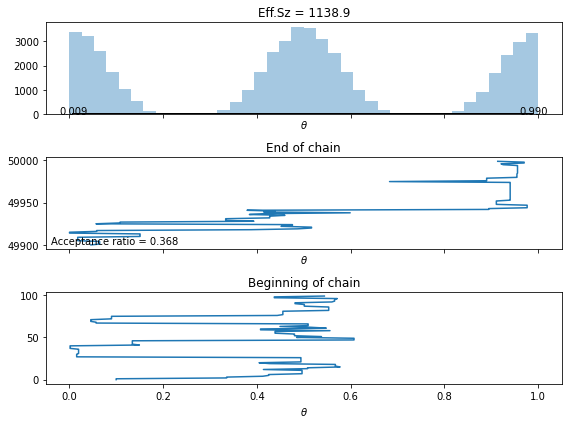

In [15]:
trace = np.array(list(metropolis_gen(prior, proposal_sd=0.2)))
plot_trace_analysis(trace)

### Question D

Sampling from the posterior.

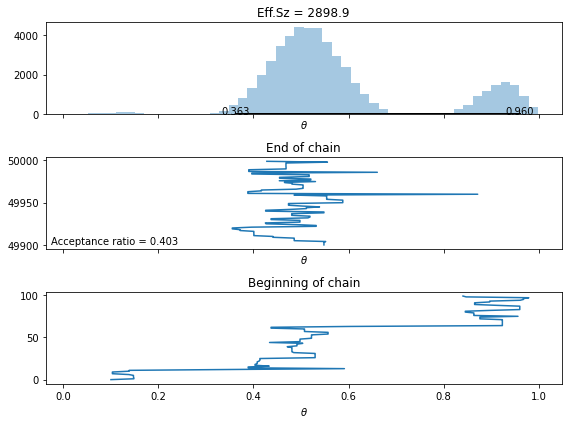

In [16]:
data = [0, 1, 1]
posterior = lambda theta: bern_likelihood(theta, data) * prior(theta)

trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.2)))
plot_trace_analysis(trace)

### Question E

Same as the above, but with narrower proposal distribution. Notice how the algorithm get stuck on some of the modes of the trimodal prior.

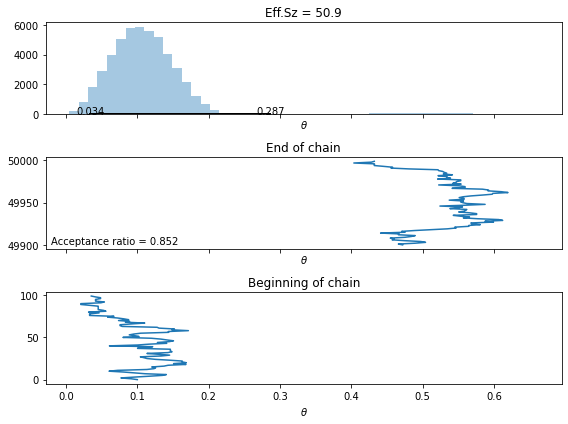

In [17]:
trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.02)))
plot_trace_analysis(trace)

This chain is not representative of the underlying distribution. A way to check that is by generating multiple chains with different starting positoins and check for convergence (Gelman-Rubin statistic, or visual check).

### Question F

Same as before (too small proposal standard deviation), but now with another starting point. The result posterior is completely different, as the algorithm now stucked at another mode of the prior.

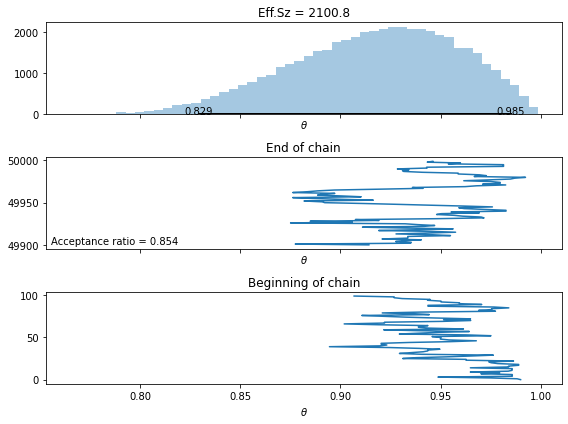

In [18]:
trace = np.array(list(metropolis_gen(posterior, proposal_sd=0.02, starting_position=0.99)))
plot_trace_analysis(trace)